# Shipping Optimization Challenge
Técnicas Avanzadas de Análisis de Datos
> Néstor Torres Díaz

## Objetivo 
Realizar una competición para el problema de regresión *Shipping Optimization Challenge* planteado en el siguiente [enlace](https://www.kaggle.com/datasets/salil007/1-shipping-optimization-challenge?resource=download), con el propósito de predecir el tiempo (*Shipping Time*), necesario para procesar con éxito cada envío. 

## Ficheros utilizados
Accediendo a la página de la competición través del enlace comentado en el anterior apartado, podremos ver los ficheros necesarios para participar en la misma.
- ``shipping_companies_details_1.csv``: Este fichero contiene toda la información necesaria sobre las empresas de transporte.
- ``submission_2.csv``: Este fichero debe ser presentado por los participantes. **No debe contener ningún id ni nombre de columna**. El orden de las variables objetivo debe ajustarse al formato del fichero pero la primera fila y la primera columna deberían eliminarse previas al envío. La competición solo aceptará archivos csv que consten únicamente de valores numéricos.
- ``test_2.csv``: Este fichero contiene datos históricos de envíos. El tiempo de envío es desconocido y debe predecirse.
- ``train_2_pr.csv``: Este fichero contiene envíos históricos comprendidos entre 2019 y 2020, con tiempos de envío conocidos y algunos otros detalles de los mismos, por lo que puede ser utilizado para entrenar el modelo que se plantee. Más de un registro en este fichero tiene el mismo `shipment_id`, pero su columna `shipping_company` es distinta.


## Carga de Librerías

In [1570]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as  plt
from scipy.stats import chi2, chi2_contingency
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

## Lectura de datos

Se cargan los conjuntos de datos y se hace una exploración inicial sobre los mismos

### Conjunto de entrenamiento

En primera instancia, se lee el conjunto de datos de entrenamiento, estableciendo el id del envío como índice y eliminando posteriormente el establecido por defecto. También se parsea la fecha almacenada en el campo `send_timestamp`. 

In [1571]:
train = pd.read_csv('data/train_2_pr.csv', index_col='shipment_id', parse_dates=['send_timestamp'])
train.drop('Unnamed: 0', axis=1, inplace=True)
train.head()

,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,selected,shipping_time
shipment_id,,,,,,,,,,,,
S000720,2019-06-08 07:17:51,A,Y,GB,IN,88.61,355.0,0.75,Air,SC3,Y,5.00741
S000725,2019-07-12 15:23:21,A,Y,GB,IN,85.65,105.0,0.90,Ocean,SC1,Y,21.41215
S000736,2019-10-04 14:23:29,A,Y,GB,IN,86.22,100.0,0.75,Air,SC3,Y,5.33692
S000738,2020-01-07 09:19:50,A,Y,GB,IN,94.43,1071.0,1.05,Air,SC2,Y,5.14792
S000739,2020-04-11 06:36:03,A,Y,GB,IN,94.24,2007.0,0.75,Air,SC3,Y,5.03067


En concreto, el conjunto de almacenamiento contiene 5114 registros de envíos para los cuales se contemplan 12 variables con información sobre los mismos.

 - **send_timestamp**: Fecha y hora en que el pedido fue enviado al país de destino, ajustada al huso horario del país de origen.
 - **pick_up_point**: Código que identifica el lugar donde se recogen las mercancías para su envío.
 - **drop_off_point**: Código que identifica el lugar donde se entregan las mercancías al final de su viaje.
 - **source_country**: País desde donde se envían las mercancías.
 - **destination_country**: País al cual se envían las mercancías.
 - **freight_cost**: Costo asociado al transporte de cada kilogramo de mercancía.
 - **gross_weight**: Peso total en kilogramos de las mercancías que se necesitan enviar.
 - **shipment_charges**: Costo fijo asociado a cada envío, independientemente del peso de la carga.
 - **shipment_mode**: Método utilizado para enviar las mercancías, como por aire, mar, etc.
 - **shipping_company**: Identificador de la compañía de envíos que es candidata para realizar el transporte de las mercancías.
 - **selected**: Indica si la compañía en `shipping_company` fue seleccionada o no para realizar el envío.
 - **shipping_time**: Duración en días que toma para que las mercancías lleguen a su destino desde el momento en que son enviadas.

Cabe añadir que el campo `shipment_id` ha sido incluído como índice, por lo tanto aquí no se referencia, pero hace alusión al identificador único del envío.

In [1572]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5114 entries, S000720 to S2082151
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   send_timestamp       5114 non-null   datetime64[ns]
 1   pick_up_point        5114 non-null   object        
 2   drop_off_point       5114 non-null   object        
 3   source_country       5114 non-null   object        
 4   destination_country  5114 non-null   object        
 5   freight_cost         5114 non-null   float64       
 6   gross_weight         5114 non-null   float64       
 7   shipment_charges     5114 non-null   float64       
 8   shipment_mode        5114 non-null   object        
 9   shipping_company     5114 non-null   object        
 10  selected             5114 non-null   object        
 11  shipping_time        5114 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 519.4+ KB


### Conjunto de Test

Con el conjunto de test, la lectura se hace de manera idéntica al conjunto de entrenamiento.

In [1573]:
test = pd.read_csv('data/test_2.csv', index_col='shipment_id', parse_dates=['send_timestamp'])
test.drop('Unnamed: 0', axis=1, inplace=True)
test.head()

,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,selected
shipment_id,,,,,,,,,,,
S002736,2019-10-04 14:27:04,A,Y,GB,IN,86.81,100.0,0.75,Air,SC3,Y
S002738,2020-01-07 09:39:35,A,Y,GB,IN,94.43,1006.0,0.75,Air,SC3,Y
S005739,2020-04-11 11:58:10,A,Y,GB,IN,93.55,321.0,1.05,Air,SC2,Y
S008722,2019-06-23 11:54:41,A,Y,GB,IN,88.74,355.0,1.05,Air,SC2,Y
S009737,2019-11-20 20:18:01,A,Y,GB,IN,92.83,115.0,1.05,Air,SC2,Y


Este conjunto está compuesto por 1260 registros para los cuales se contemplan exactamente las mismas variables que para el conjunto de entrenamiento, a excepción de la variable objetivo `shipping_time`. 

In [1574]:
test[['shipping_company','shipment_charges']].value_counts()

shipping_company  shipment_charges
SC1               0.9000              503
SC3               0.7500              421
SC2               1.0500              266
                  0.5625               53
SC1               1.1250               17
Name: count, dtype: int64

In [1575]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1260 entries, S002736 to S9443149
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   send_timestamp       1260 non-null   datetime64[ns]
 1   pick_up_point        1260 non-null   object        
 2   drop_off_point       1260 non-null   object        
 3   source_country       1260 non-null   object        
 4   destination_country  1260 non-null   object        
 5   freight_cost         1260 non-null   float64       
 6   gross_weight         1260 non-null   float64       
 7   shipment_charges     1260 non-null   float64       
 8   shipment_mode        1260 non-null   object        
 9   shipping_company     1260 non-null   object        
 10  selected             1260 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 118.1+ KB


### Conjunto de Detalles de Compañias de Transporte

Este conjunto de datos contiene información sobre las diferentes compañías de transporte que se hacen cargo de los envíos.

In [1576]:
details = pd.read_csv('data/shipping_companies_details_1.csv')
details.head()

,source_country,destination_country,shipment_mode,cut_off_time,tat,processing_days,pick_up_point,drop_off_point,min_cs,max_cs,shipping_company,shipment_charges
0,GB,IN,Ocean,12PM IST,Before CO - T+0\nAfter CO - T+1,Mon-Fri,A,Y,100,"2,500,000",SC1,0.9000
1,GB,IN,Air,24/7,Real-time,24/7,A,Y,100,"200,000",SC2,1.0500
2,GB,IN,Air,24/7,Within 15 mins,24/7,A,Y,100,"200,000",SC3,0.7500
3,GB,BD,Ocean,10 - 2 and 3 - 6 BST,Before CO - T+0\nAfter CO - T+1,Sun-Fri,A,X,50,"4,000,000",SC1,1.1250
4,GB,BD,Ocean,10 - 2 and 3 - 6 BST,Before CO - T+0\nAfter CO - T+1,Sun-Fri,A,X,50,"4,000,000",SC2,0.5625


En concreto, este conjunto de datos solo contiene 5 registros, para los cuales se tienen en cuenta 12 variables. Se puede ver como contiene muchos campos que coinciden con los vistos en los anteriores conjuntos de datos, lo cual significa que si los campos que tienen en común contienen los mismos valores se podrían llegar a combinar los conjuntos de datos para completar aún más la información.
- **source_country**: País desde donde se envían las mercancías.
- **destination_country**: País al cual se envían las mercancías.
- **shipment_mode**: Método utilizado para enviar las mercancías, como por aire, mar, etc.
- **cut_off_time**: Ventana de tiempo durante la cual las mercancías pueden ser recogidas. Por ejemplo, "10 - 2 y 3 - 6 BST" indica que la recogida está disponible entre las 10 a.m. y las 2 p.m., y nuevamente entre las 3 p.m. y las 6 p.m., todas las horas en Horario Estándar de Bangladesh.
- **tat**: Tiempo que toma desde que se realiza el pedido del paquete hasta su envío. "T" se refiere a la hora en que se envió el paquete, y "CO" significa hora de corte, o la hora después de la cual el paquete ya no puede ser enviado. "Before CO - T+0" y "After CO - T+1" significa que si las mercancías se envían a la compañía de transporte antes de la hora de corte, entonces el paquete será enviado el mismo día, de lo contrario será enviado al día siguiente.
- **processing_days**: Días en los que el punto de recogida está operativo.
- **pick_up_point**: Código que identifica el lugar donde se recogen las mercancías para su envío.
- **drop_off_point**: Código que identifica el lugar donde se entregan las mercancías al final de su viaje.
- **min_cs**: Costo mínimo asociado con el envío de mercancías.
- **max_cs**: Costo máximo asociado con el envío de mercancías.
- **shipping_company**: Identificador de la compañía de envíos que es candidata para realizar el transporte de las mercancías.
- **shipment_charges**: Costo fijo asociado a cada envío, independientemente del peso de la carga.

In [1577]:
details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   source_country       5 non-null      object 
 1   destination_country  5 non-null      object 
 2   shipment_mode        5 non-null      object 
 3   cut_off_time         5 non-null      object 
 4   tat                  5 non-null      object 
 5   processing_days      5 non-null      object 
 6   pick_up_point        5 non-null      object 
 7   drop_off_point       5 non-null      object 
 8   min_cs               5 non-null      int64  
 9   max_cs               5 non-null      object 
 10  shipping_company     5 non-null      object 
 11  shipment_charges     5 non-null      float64
dtypes: float64(1), int64(1), object(10)
memory usage: 612.0+ bytes


## Integración de Conjuntos de Datos
En este apartado se integran los datos de detalles de las compañías con los conjuntos de entrenamiento y de test, de manera que la información esté lo más completa posible.

### Conjunto de entrenamiento
En concreto, hemos visto que los campos que tienen en común el conjunto de entrenamiento y el conjunto de detalles de las compañías de transporte son los campos:
 - `source_country`
 - `destination_country`
 - `shipment_mode`
 - `pick_up_point`
 - `drop_off_point`
 - `shipping_company`
 - `shipment_charges`

Por lo tanto, se comprueba que los valores presentados para dichos campos en ambos conjuntos de datos, no contengan ningún tipo de espacio o símbolo no deseado o que al menos manejen los mismos valores.

In [1578]:
common_fields = ['source_country', 'destination_country', 'shipment_mode', 'pick_up_point', 'drop_off_point', 'shipping_company', 'shipment_charges']

In [1579]:
def check_for_differences(a_df, b_df, fields):
    for field in fields:
        unique_a_df = set(a_df[field].unique())
        unique_b_df = set(b_df[field].unique())

        a_minus_b = unique_a_df - unique_b_df
        b_minus_a = unique_b_df - unique_a_df
        if (len(a_minus_b) > 0):
            print(field, "- Valores en a que no están en b ->", a_minus_b)
        if (len(b_minus_a) > 0):
            print(field,"- Valores en b que no están en a ->", b_minus_a)
        if ((len(b_minus_a) == 0) and (len(a_minus_b) == 0)):
            print(field,"- Manejan los mismos valores ->", unique_a_df)

In [1580]:
check_for_differences(train, details, common_fields)

source_country - Manejan los mismos valores -> {'GB'}
destination_country - Manejan los mismos valores -> {'IN', 'BD'}
shipment_mode - Manejan los mismos valores -> {'Air', 'Ocean'}
pick_up_point - Manejan los mismos valores -> {'A'}
drop_off_point - Valores en a que no están en b -> {'X', 'Y'}
drop_off_point - Valores en b que no están en a -> {' Y ', ' X '}
shipping_company - Manejan los mismos valores -> {'SC3', 'SC2', 'SC1'}
shipment_charges - Manejan los mismos valores -> {0.75, 0.9, 1.125, 1.05, 0.5625}


Al hacer estas comprobaciones nos encontramos con que los valores utilizados en el conjunto de datos `details` para el campo `drop_off_point` difiere de los valores utilizados en el conjunto de `train`. En concreto vemos que hay espacios por delante y detrás, así que procedemos a eliminarlos.

In [1581]:
details['drop_off_point'] = details['drop_off_point'].str.strip()
check_for_differences(train, details, ['drop_off_point'])

drop_off_point - Manejan los mismos valores -> {'X', 'Y'}


Ahora que sabemos que manejan los mismos valores, procedemos a combinarlos en un único conjunto de entrenamiento que contendrá también la información de detalles sobre las compañias de transporte.

In [1582]:

train = pd.merge(train, details, on=common_fields, how='inner')
train.head()

,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,selected,shipping_time,cut_off_time,tat,processing_days,min_cs,max_cs
0,2019-06-08 07:17:51,A,Y,GB,IN,88.61,355.0,0.75,Air,SC3,Y,5.00741,24/7,Within 15 mins,24/7,100,"200,000"
1,2019-10-04 14:23:29,A,Y,GB,IN,86.22,100.0,0.75,Air,SC3,Y,5.33692,24/7,Within 15 mins,24/7,100,"200,000"
2,2020-04-11 06:36:03,A,Y,GB,IN,94.24,2007.0,0.75,Air,SC3,Y,5.03067,24/7,Within 15 mins,24/7,100,"200,000"
3,2019-05-27 11:53:23,A,Y,GB,IN,87.84,228.7,0.75,Air,SC3,Y,5.18611,24/7,Within 15 mins,24/7,100,"200,000"
4,2019-06-08 07:46:01,A,Y,GB,IN,89.00,119.0,0.75,Air,SC3,Y,5.22060,24/7,Within 15 mins,24/7,100,"200,000"


### Conjunto de test
En concreto, hemos visto que los campos que tienen en común el conjunto de test y el conjunto de detalles de las compañías de transporte son los mismos campos y por lo tanto, se comprueba también que los valores presentados para dichos campos en ambos conjuntos de datos, no contengan ningún tipo de espacio o símbolo no deseado o que al menos manejen los mismos valores.

In [1583]:
check_for_differences(test, details, common_fields)

source_country - Manejan los mismos valores -> {'GB'}
destination_country - Manejan los mismos valores -> {'IN', 'BD'}
shipment_mode - Manejan los mismos valores -> {'Air', 'Ocean'}
pick_up_point - Manejan los mismos valores -> {'A'}
drop_off_point - Manejan los mismos valores -> {'X', 'Y'}
shipping_company - Manejan los mismos valores -> {'SC3', 'SC2', 'SC1'}
shipment_charges - Manejan los mismos valores -> {0.75, 1.05, 1.125, 0.5625, 0.9}


En este caso nos encontramos con que ambos conjuntos de datos manejan los mismos valores y además estos no contienen ningún espacio ni símbolo no deseado, por lo que podemos proceder a integrar los datos de detalles de las compañías de transporte con el conjunto de test, dejando un nuevo conjunto de test más completo.

In [1584]:
test = pd.merge(test, details, on=common_fields, how='inner')
test.head()

,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,selected,cut_off_time,tat,processing_days,min_cs,max_cs
0,2019-10-04 14:27:04,A,Y,GB,IN,86.81,100.0,0.75,Air,SC3,Y,24/7,Within 15 mins,24/7,100,"200,000"
1,2020-01-07 09:39:35,A,Y,GB,IN,94.43,1006.0,0.75,Air,SC3,Y,24/7,Within 15 mins,24/7,100,"200,000"
2,2019-11-20 20:30:05,A,Y,GB,IN,92.48,115.0,0.75,Air,SC3,Y,24/7,Within 15 mins,24/7,100,"200,000"
3,2020-04-11 14:53:25,A,Y,GB,IN,94.45,325.0,0.75,Air,SC3,Y,24/7,Within 15 mins,24/7,100,"200,000"
4,2019-03-23 06:39:22,A,Y,GB,IN,90.39,61.0,0.75,Air,SC3,Y,24/7,Within 15 mins,24/7,100,"200,000"


## Análisis Exploratorio de Datos (EDA)

### Análisis descriptivo

Puesto que se ha llevado a cabo la integración de los datos de entrenamiento y de test con el conjunto de detalles sobre compañias de transporte, el análisis se centrará principalmente en los conjuntos resultantes de esa combinación, más concretamente en el de entrenamiento. Aún así, cabe destacar que la variable "shipping_time" sólo está en el conjunto de entrenamiento.

In [1585]:
field_differences = set(train.columns) - set(test.columns)
print("Campos presentes en el conjunto de entrenamiento que no están en el de test: ", field_differences)

Campos presentes en el conjunto de entrenamiento que no están en el de test:  {'shipping_time'}


Comprobamos nuevamente la información de este conjunto de entrenamiento, donde recordamos lo que representa cada variable:

 - **send_timestamp**: Fecha y hora en que el pedido fue enviado al país de destino, ajustada al huso horario del país de origen.
 - **pick_up_point**: Código que identifica el lugar donde se recogen las mercancías para su envío.
 - **drop_off_point**: Código que identifica el lugar donde se entregan las mercancías al final de su viaje.
 - **source_country**: País desde donde se envían las mercancías.
 - **destination_country**: País al cual se envían las mercancías.
 - **freight_cost**: Costo asociado al transporte de cada kilogramo de mercancía.
 - **gross_weight**: Peso total en kilogramos de las mercancías que se necesitan enviar.
 - **shipment_charges**: Costo fijo asociado a cada envío, independientemente del peso de la carga.
 - **shipment_mode**: Método utilizado para enviar las mercancías, como por aire, mar, etc.
 - **shipping_company**: Identificador de la compañía de envíos que es candidata para realizar el transporte de las mercancías.
 - **selected**: Indica si la compañía en `shipping_company` fue seleccionada o no para realizar el envío.
 - **shipping_time**: Duración en días que toma para que las mercancías lleguen a su destino desde el momento en que son enviadas.
 - **cut_off_time**: Ventana de tiempo durante la cual las mercancías pueden ser recogidas. Por ejemplo, "10 - 2 y 3 - 6 BST" indica que la recogida está disponible entre las 10 a.m. y las 2 p.m., y nuevamente entre las 3 p.m. y las 6 p.m., todas las horas en Horario Estándar de Bangladesh.
- **tat**: Tiempo que toma desde que se realiza el pedido del paquete hasta su envío. "T" se refiere a la hora en que se envió el paquete, y "CO" significa hora de corte, o la hora después de la cual el paquete ya no puede ser enviado. "Before CO - T+0" y "After CO - T+1" significa que si las mercancías se envían a la compañía de transporte antes de la hora de corte, entonces el paquete será enviado el mismo día, de lo contrario será enviado al día siguiente.
- **processing_days**: Días en los que el punto de recogida está operativo.
- **min_cs**: Costo mínimo asociado con el envío de mercancías.
- **max_cs**: Costo máximo asociado con el envío de mercancías.

Cabe añadir que el campo `shipment_id` ha sido incluído como índice, por lo tanto aquí no se referencia, pero hace alusión al identificador único del envío.

Por un lado, vemos que *no se encuentran registros nulos* para ninguna de las variables del dataset y además se observa algún que otro *tipo de datos que está mal asignado*, como puede ser `max_cs` que representa el costo máximo asociado al envío, es decir, un valor numérico y está siendo tratado como un `object` mientras que el costo mínimo asociado al envío, que debería tener el mismo formato numérico, está siendo tratado como un `int64`. 

In [1586]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5114 entries, 0 to 5113
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   send_timestamp       5114 non-null   datetime64[ns]
 1   pick_up_point        5114 non-null   object        
 2   drop_off_point       5114 non-null   object        
 3   source_country       5114 non-null   object        
 4   destination_country  5114 non-null   object        
 5   freight_cost         5114 non-null   float64       
 6   gross_weight         5114 non-null   float64       
 7   shipment_charges     5114 non-null   float64       
 8   shipment_mode        5114 non-null   object        
 9   shipping_company     5114 non-null   object        
 10  selected             5114 non-null   object        
 11  shipping_time        5114 non-null   float64       
 12  cut_off_time         5114 non-null   object        
 13  tat                  5114 non-nul

Este conjunto de datos está compuesto por 5114 registros y 17 variables.

In [1587]:
train.shape

(5114, 17)

Se comprueban también la cantidad de valores únicos para cada variable, de manera que podamos distinguir la cantidad de valores distintos que puede tomar cada una de ellas.

En este caso vemos que las variables `pick_up_point`, `source_country` y `selected` sólo toman un valor, lo que podría introducir ruido en nuestro conjunto de datos al considerarse información redundante.

El resto de variables que toman de de 2 a 3 valores distintos habría que analizarlas más en profundidad para ver su frecuencia y posiblemente tratarlas como variables categóricas.

In [1588]:
train.nunique()

send_timestamp         4804
pick_up_point             1
drop_off_point            2
source_country            1
destination_country       2
freight_cost           2000
gross_weight           1301
shipment_charges          5
shipment_mode             2
shipping_company          3
selected                  1
shipping_time          4315
cut_off_time              3
tat                       3
processing_days           3
min_cs                    2
max_cs                    3
dtype: int64


Si nos fijamos en la distribución y las características de los datos podemos ver que para la mayor parte de las variables tienen una media y una mediana (percentil 50%) similares, lo que podría indicar una distribución normal de los datos. Sin embargo, cabe destacar que tanto en el tiempo de envío (`shipping_time`) como en el peso de la mercancía (`gross_weight`), estos valores difieren bastante más, pudiendo indicar cierto sesgo o asimetría en la distribución.

In [1589]:
train.describe()

,send_timestamp,freight_cost,gross_weight,shipment_charges,shipping_time,min_cs
count,5114,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000
mean,2019-09-07 04:42:55.320883712,91.200923,954.074099,0.871732,12.641822,97.096206
min,2019-02-14 05:55:30,82.885600,5.000000,0.562500,5.000000,50.000000
25%,2019-05-18 11:25:32.750000128,87.750000,225.000000,0.750000,5.199910,100.000000
50%,2019-09-01 11:21:45,90.750000,505.000000,0.900000,5.405150,100.000000
75%,2019-12-11 00:16:49.249999872,92.837500,1100.000000,0.900000,19.644270,100.000000
max,2020-06-13 15:30:11,115.620000,10000.000000,1.125000,57.249650,100.000000
std,NaN,5.154340,1266.102859,0.127972,10.273164,11.695487


### Análisis de duplicados

No se han encontrado registros duplicados.

In [1590]:
train.duplicated().sum()

0

### Análisis de valores faltantes

Tal y como se había comentado con anterioridad, tampoco se han encontrado valores nulos en ninguna de las variables.

In [1591]:
train.isnull().sum()

send_timestamp         0
pick_up_point          0
drop_off_point         0
source_country         0
destination_country    0
freight_cost           0
gross_weight           0
shipment_charges       0
shipment_mode          0
shipping_company       0
selected               0
shipping_time          0
cut_off_time           0
tat                    0
processing_days        0
min_cs                 0
max_cs                 0
dtype: int64

### Visualización de datos

Para comprender mejor los datos, se plantean histogramas, diagramas de barras y boxplots para ilustrar la distribución de los mismos, así como también se plantea la matriz de correlaciones para ver las relaciones entre las variables.

Primero que nada, convertiremos la variable `max_cs` a numérica. Aprovechando esto, lo llevamos a cabo también en el conjunto de test.

In [1592]:
# Elimino espacios en blanco
train['max_cs'] = train['max_cs'].str.strip()
test['max_cs'] = test['max_cs'].str.strip()
# Elimino las comas
train['max_cs'] = train['max_cs'].str.replace(',','')
test['max_cs'] = test['max_cs'].str.replace(',','')
# Lo convierto a entero
train['max_cs'] = train['max_cs'].astype('int64')
test['max_cs'] = test['max_cs'].astype('int64')


print(train['max_cs'].value_counts())
print(test['max_cs'].value_counts())

max_cs
200000     2664
2500000    2153
4000000     297
Name: count, dtype: int64
max_cs
200000     687
2500000    503
4000000     70
Name: count, dtype: int64


#### Histogramas

Primero que nada, indicamos las variables numéricas que van a usarse en los histogramas.

In [1593]:
numeric_columns = train.select_dtypes(include=['number']).columns
print(numeric_columns)

Index(['freight_cost', 'gross_weight', 'shipment_charges', 'shipping_time',
       'min_cs', 'max_cs'],
      dtype='object')


Se presentan los histogramas para las variables numéricas.

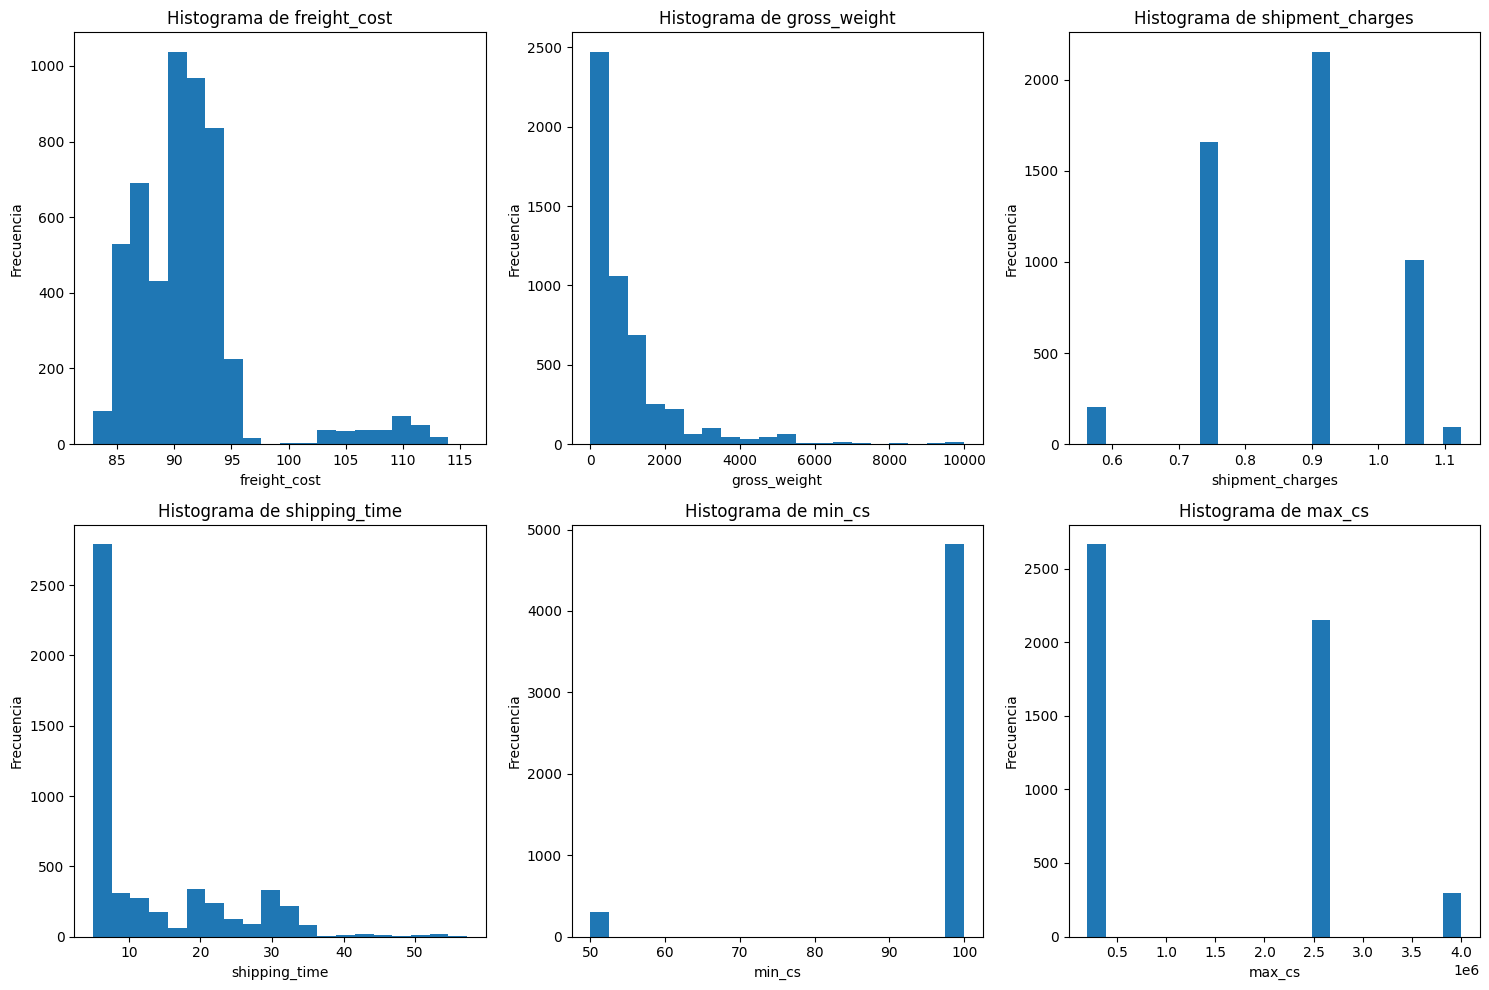

In [1594]:
num_cols = 3
num_rows = -(-len(numeric_columns) // num_cols) # Numero de filas, usando la division entera hacia arriba

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    axes[i].hist(train[column], bins=20)
    axes[i].set_title(f'Histograma de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frecuencia')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Diagramas de barras

En este caso nos quedamos con las columnas que representan categorías, o al menos aquellas que manejan un pequeño rango de valores.

In [1595]:
categorical_columns = train.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['pick_up_point', 'drop_off_point', 'source_country',
       'destination_country', 'shipment_mode', 'shipping_company', 'selected',
       'cut_off_time', 'tat', 'processing_days'],
      dtype='object')


A continuación se muestran los diagramas de barras de las variables categóricas.

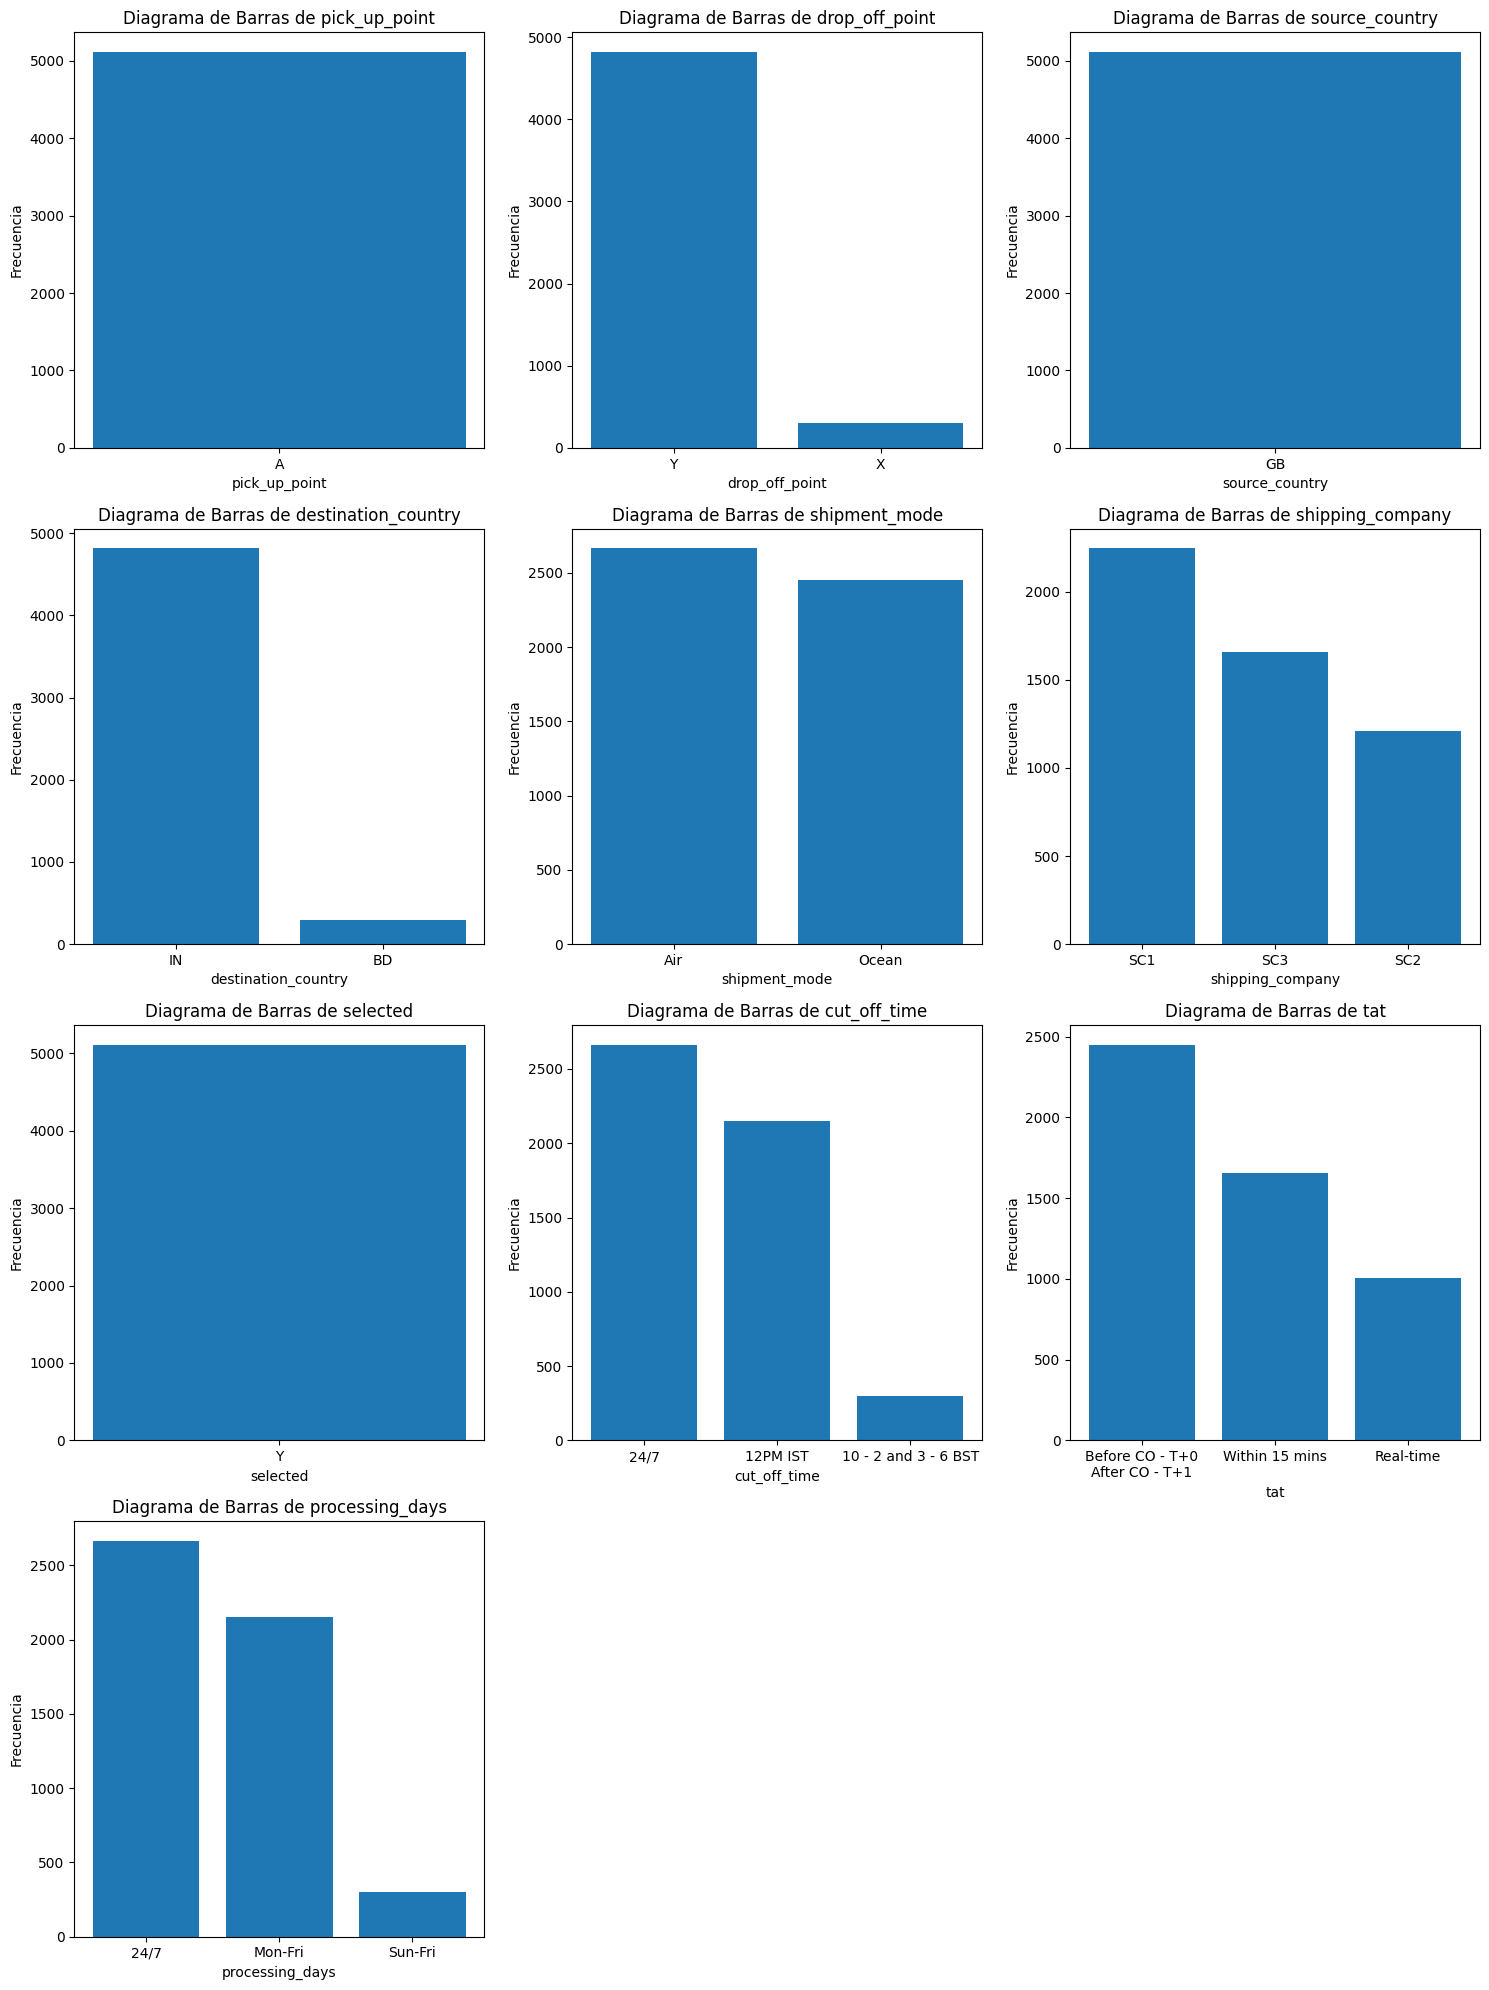

In [1596]:
num_cols = 3
num_rows = -(-len(categorical_columns) // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    value_counts = train[column].value_counts()
    axes[i].bar(value_counts.index, value_counts.values)
    axes[i].set_title(f'Diagrama de Barras de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frecuencia')

for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Correlación entre variables

Para llevar a cabo el estudio de las correlaciones se utilizará en este caso el método de pearson.

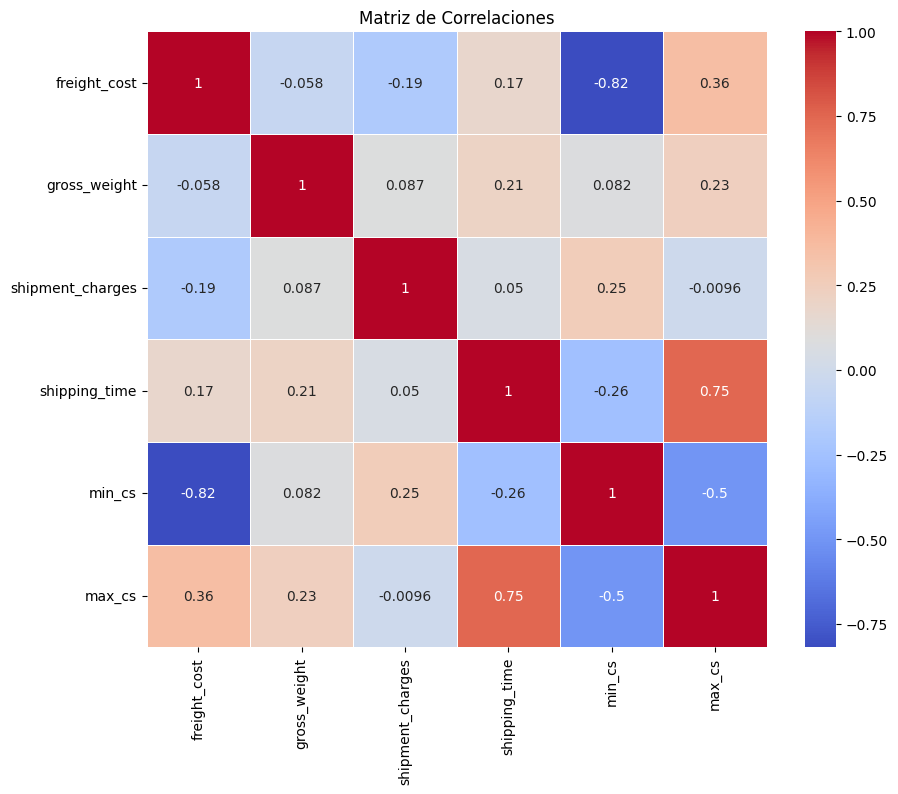

In [1597]:
corr_matrix = train.corr(method='pearson', numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlaciones')
plt.show()


                     drop_off_point  destination_country  shipment_mode  \
drop_off_point             1.000000             0.998212       0.257734   
destination_country        0.998212             1.000000       0.257734   
shipment_mode              0.257734             0.257734       1.000000   
shipping_company           0.271409             0.271409       0.931334   
cut_off_time               0.999902             0.999902       0.999902   
tat                        0.258194             0.258194       0.999902   
processing_days            0.999902             0.999902       0.999902   

                     shipping_company  cut_off_time       tat  processing_days  
drop_off_point               0.271409      0.999902  0.258194         0.999902  
destination_country          0.271409      0.999902  0.258194         0.999902  
shipment_mode                0.931334      0.999902  0.999902         0.999902  
shipping_company             1.000000      0.714903  0.938965         0.714

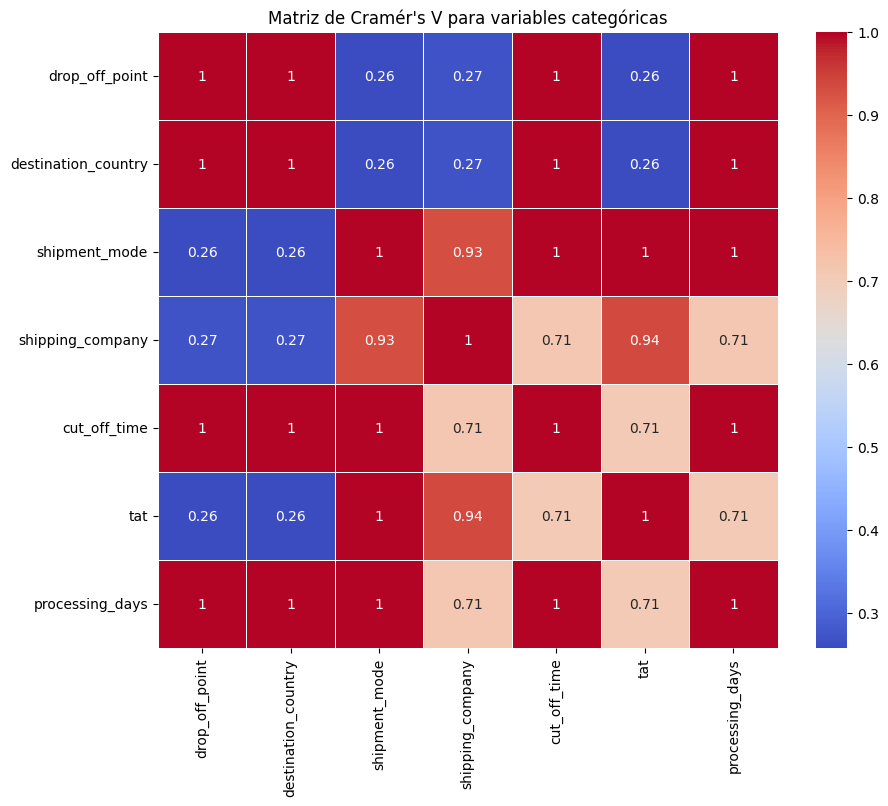

In [1598]:
def cramers_v(confusion_matrix):
    chi2_stat = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2_stat / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denominator = min((kcorr-1), (rcorr-1))
    if denominator == 0:
        return np.nan  # o 0 o algún otro valor que consideres adecuado
    return np.sqrt(phi2corr / denominator)

# Seleccionamos las variables categoricas
categorical_columns = train.select_dtypes(include=['object']).columns
columns_with_only_one_value = ['selected', 'pick_up_point', 'source_country']

# Eliminamos de las categoricas aquellas variables que solo toman un valor.
categorical_columns = [col for col in categorical_columns if col not in columns_with_only_one_value]

n = len(categorical_columns)
# Crear un DataFrame vacío para almacenar los resultados
results = pd.DataFrame(np.zeros((n, n)), index=categorical_columns, columns=categorical_columns)

# Calcular Cramér's V para cada par de variables categóricas
for i in range(n):
    for j in range(i, n):
        if i == j:
            results.iloc[i, j] = 1.0
        else:
            confusion_matrix = pd.crosstab(train[categorical_columns[i]], train[categorical_columns[j]])
            results.iloc[i, j] = cramers_v(confusion_matrix)
            results.iloc[j, i] = results.iloc[i, j]

print(results)
# Visualizar la matriz de Cramér's V
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Cramér's V para variables categóricas")
plt.show()

¿Deberia hacer algo con las variables dependientes?

In [1599]:
# Seleccionar solo las columnas categóricas
categorical_columns = train.select_dtypes(include=['object', 'category']).columns

# Función para crear matriz de confusión y realizar la prueba de Chi-cuadrado
def analyze_categorical_relationship(train, col1, col2):
    cm = pd.crosstab(train[col1], train[col2])
    chi2, p, dof, ex = chi2_contingency(cm)
    return cm, chi2, p

significance_level = 0.05
print("\nVariables categóricas dependientes (p-value < 0.05):")
for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        col1 = categorical_columns[i]
        col2 = categorical_columns[j]
        cm, chi2, p = analyze_categorical_relationship(train, col1, col2)
        if p < significance_level:
            print(f"{col1} vs {col2}:")
            print(cm)
            print(f"Chi2 = {chi2}, p-value = {p}\n")


Variables categóricas dependientes (p-value < 0.05):
drop_off_point vs destination_country:
destination_country   BD    IN
drop_off_point                
X                    297     0
Y                      0  4817
Chi2 = 5095.735824534461, p-value = 0.0

drop_off_point vs shipment_mode:
shipment_mode    Air  Ocean
drop_off_point             
X                  0    297
Y               2664   2153
Chi2 = 340.6410947788055, p-value = 4.626493400314051e-76

drop_off_point vs shipping_company:
shipping_company   SC1   SC2   SC3
drop_off_point                    
X                   94   203     0
Y                 2153  1008  1656
Chi2 = 378.63916999219157, p-value = 6.019340623911155e-83

drop_off_point vs cut_off_time:
cut_off_time    10 - 2 and 3 - 6 BST  12PM IST  24/7
drop_off_point                                      
X                                297         0     0
Y                                  0      2153  2664
Chi2 = 5114.0, p-value = 0.0

drop_off_point vs tat:
tat  

#### Boxplots

¿Deberia eliminar outliers o tratarlos o simplemente dejarlos?

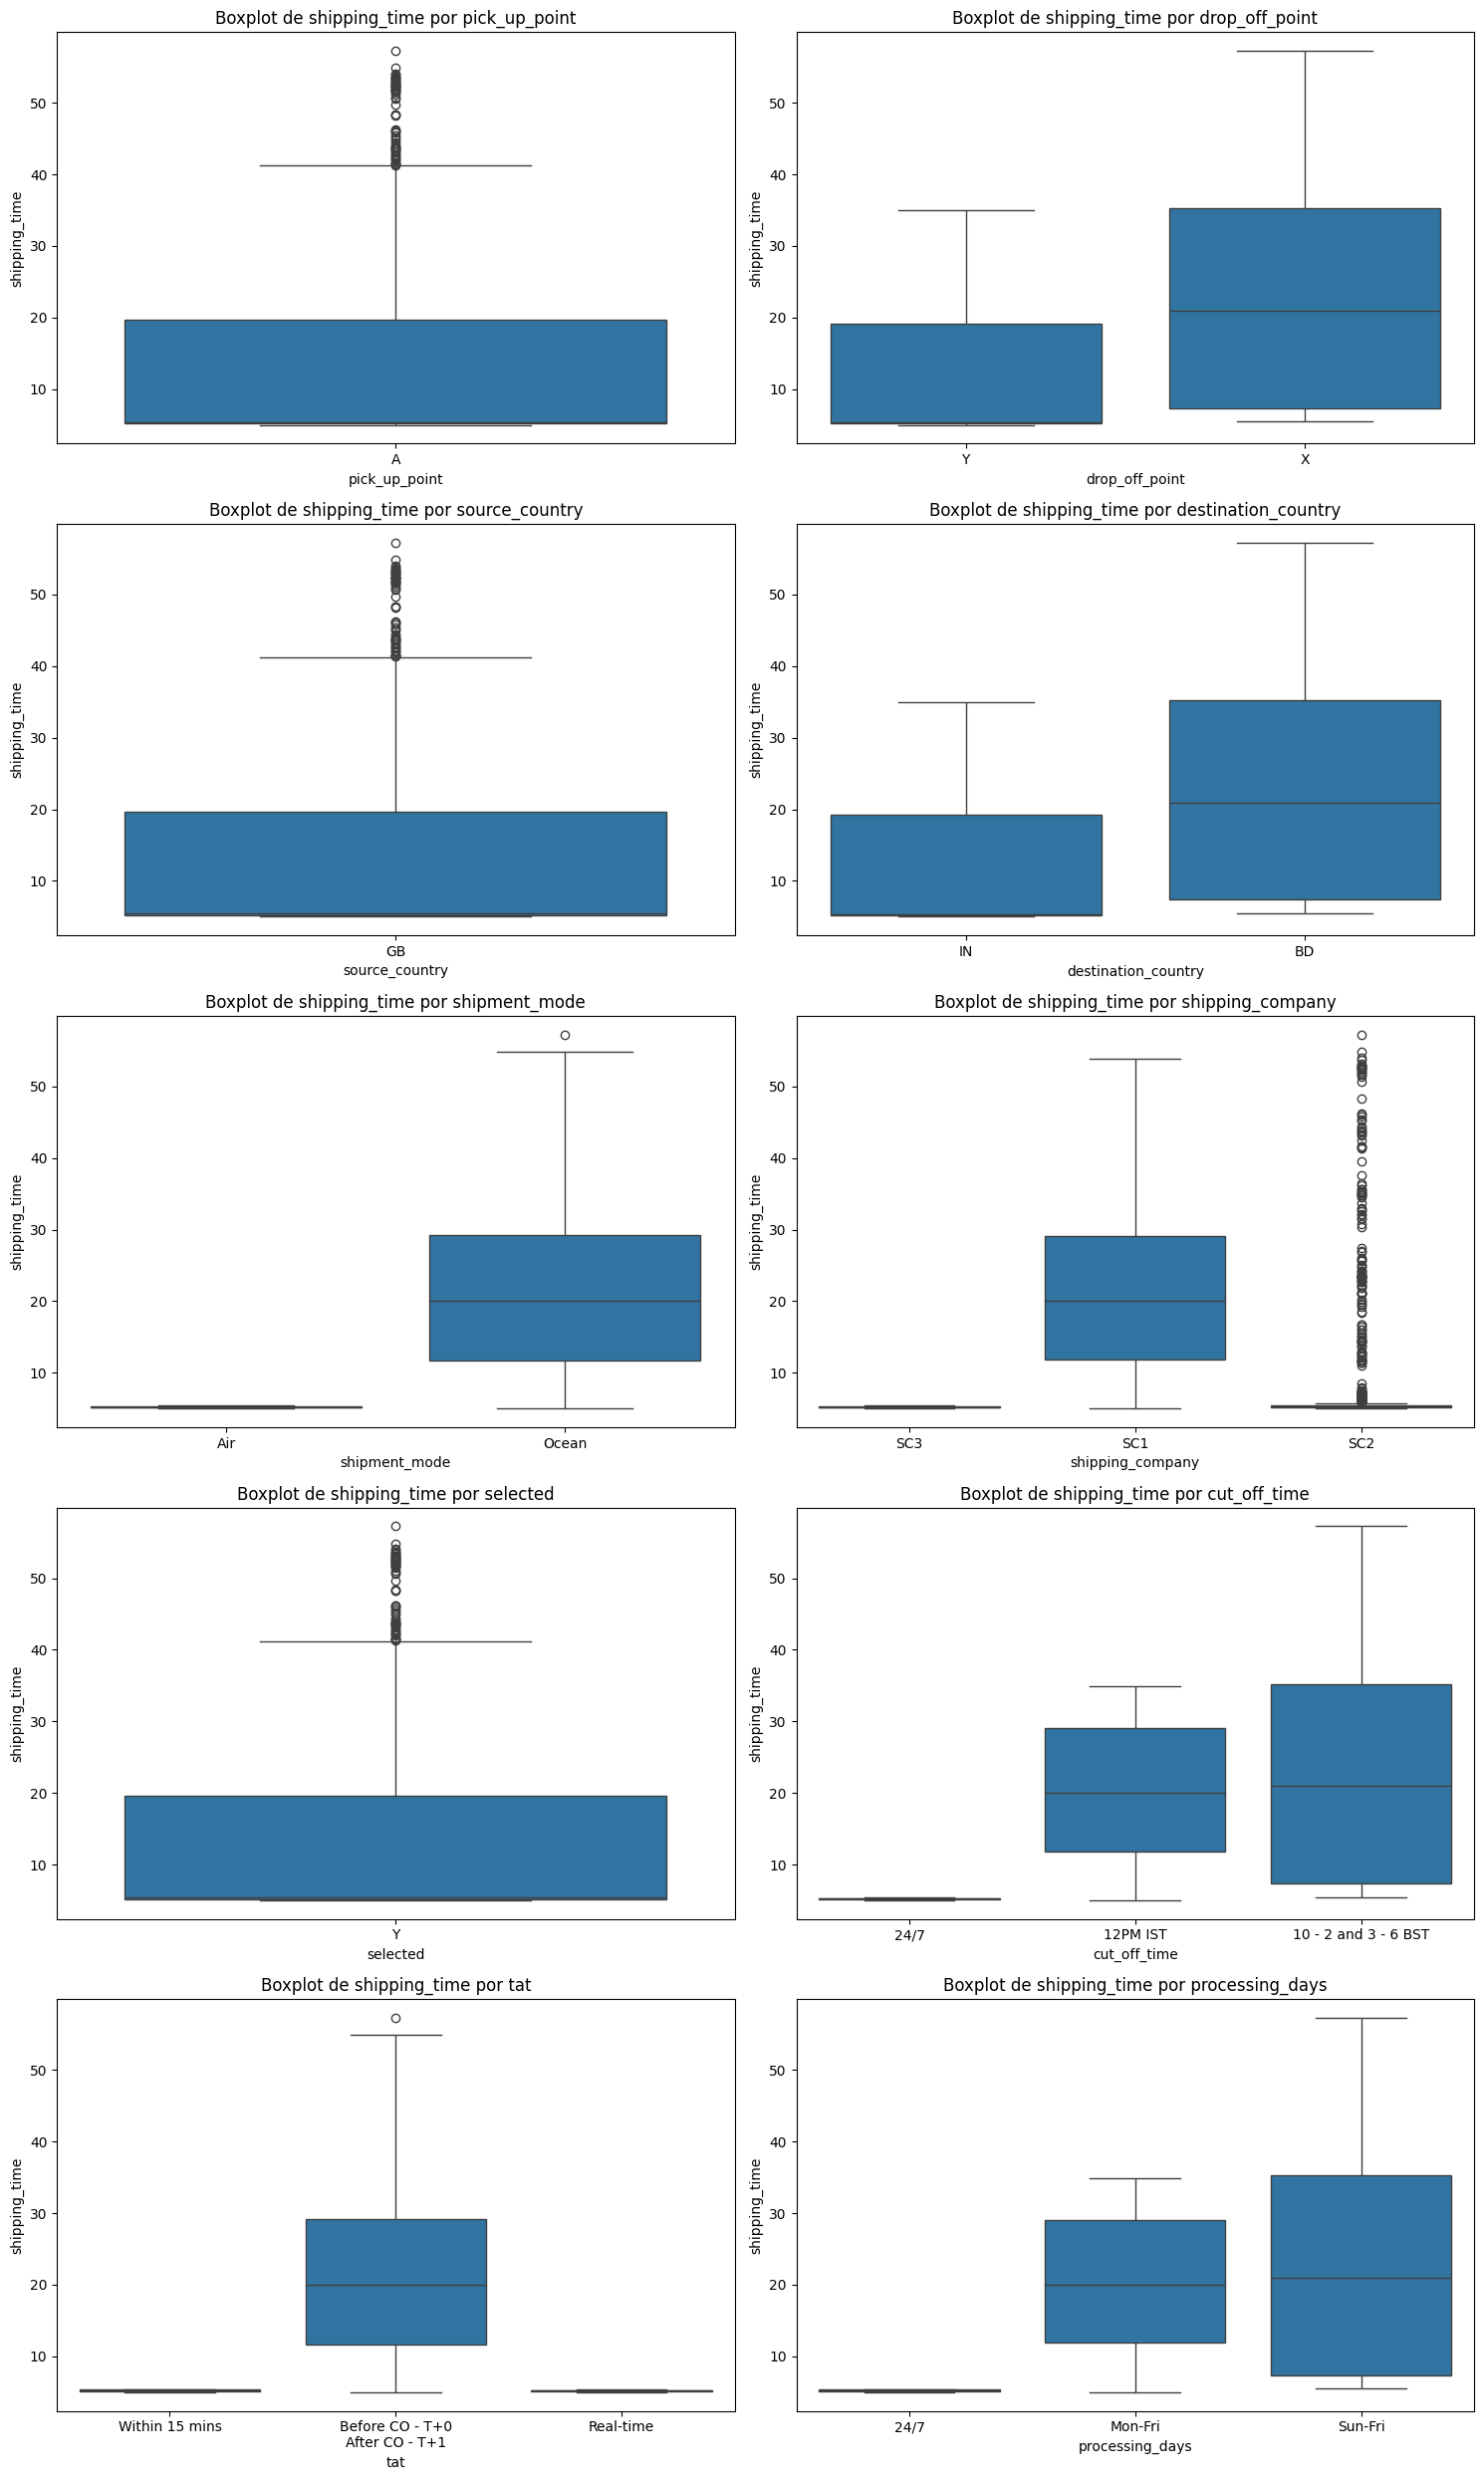

In [1600]:
# Seleccionar solo las columnas categóricas
categorical_columns = train.select_dtypes(include=['object', 'category']).columns

# Calcular el número de filas y columnas para los subgráficos
num_cols = 2  # Número de columnas en la cuadrícula de subgráficos
num_rows = -(-len(categorical_columns) // num_cols)  # Número de filas, usando la división entera hacia arriba

# Crear los subgráficos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Aplanar los ejes para facilitar la iteración si hay más de una fila
axes = axes.flatten()

# Generar boxplots para todas las variables categóricas
for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='shipping_time', data=train, ax=axes[i])
    axes[i].set_title(f'Boxplot de shipping_time por {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('shipping_time')

# Eliminar subgráficos vacíos si hay alguno
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño para que los subgráficos no se superpongan
plt.tight_layout()
plt.show()

## Preprocesamiento de los datos

### Cambio de Tipos

In [1601]:
train['send_timestamp'] = train['send_timestamp'].astype(np.int64) // 10**9
test['send_timestamp'] = test['send_timestamp'].astype(np.int64) // 10**9

### Eliminando variables redundantes

Tal y como comentamos con anterioridad, no tiene sentido mantener en el conjunto de datos variables que sólo toman un valor, por lo que se procede a su eliminación.



In [1602]:
columns_to_drop = ['selected', 'pick_up_point', 'source_country']
train.drop(columns=columns_to_drop, axis=1, inplace=True)
test.drop(columns=columns_to_drop, axis=1, inplace=True)

### Actualizando valores

In [1603]:
print(train['shipment_mode'].unique())
train['shipment_mode'] = train['shipment_mode'].replace({ 'Air': 'AIR', 'Ocean': 'OCEAN'})
test['shipment_mode'] = test['shipment_mode'].replace({ 'Air': 'AIR', 'Ocean': 'OCEAN'})
print(train['shipment_mode'].unique())

['Air' 'Ocean']
['AIR' 'OCEAN']


In [1604]:
print(train['tat'].unique())
train['tat'] = train['tat'].replace({ 'Within 15 mins': 'WITHIN_15_MINS', 'Before CO - T+0\nAfter CO - T+1': 'BEF_AFT_CO', 'Real-time': 'REAL_TIME'})
test['tat'] = test['tat'].replace({ 'Within 15 mins': 'WITHIN_15_MINS', 'Before CO - T+0\nAfter CO - T+1': 'BEF_AFT_CO', 'Real-time': 'REAL_TIME'})
print(train['tat'].unique())

['Within 15 mins' 'Before CO - T+0\nAfter CO - T+1' 'Real-time']
['WITHIN_15_MINS' 'BEF_AFT_CO' 'REAL_TIME']


In [1605]:
print(train['processing_days'].unique())
train['processing_days'] = train['processing_days'].replace({ '24/7': 'ALL_DAY', 'Mon-Fri': 'MON_FRI', 'Sun-Fri': 'SUN_FRI'})
test['processing_days'] = test['processing_days'].replace({ '24/7': 'ALL_DAY', 'Mon-Fri': 'MON_FRI', 'Sun-Fri': 'SUN_FRI'})
print(train['processing_days'].unique())

['24/7' 'Mon-Fri' 'Sun-Fri']
['ALL_DAY' 'MON_FRI' 'SUN_FRI']


In [1606]:
print(train['cut_off_time'].unique())
train['cut_off_time'] = train['cut_off_time'].replace({ '24/7': 'ALL_DAY', '12PM IST': 'IST', '10 - 2 and 3 - 6 BST': 'BST'})
test['cut_off_time'] = test['cut_off_time'].replace({ '24/7': 'ALL_DAY', '12PM IST': 'IST', '10 - 2 and 3 - 6 BST': 'BST'})
print(train['cut_off_time'].unique())

['24/7' '12PM IST' '10 - 2 and 3 - 6 BST']
['ALL_DAY' 'IST' 'BST']


### Codificación de variables categóricas

In [1607]:
categorical_columns = train.select_dtypes(include=['object']).columns

train = pd.get_dummies(train, columns=categorical_columns)
test = pd.get_dummies(test, columns=categorical_columns)

for col in train.select_dtypes(include='bool').columns:
    train[col] = train[col].astype('uint8')
    test[col] = test[col].astype('uint8')
    
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5114 entries, 0 to 5113
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   send_timestamp           5114 non-null   int64  
 1   freight_cost             5114 non-null   float64
 2   gross_weight             5114 non-null   float64
 3   shipment_charges         5114 non-null   float64
 4   shipping_time            5114 non-null   float64
 5   min_cs                   5114 non-null   int64  
 6   max_cs                   5114 non-null   int64  
 7   drop_off_point_X         5114 non-null   uint8  
 8   drop_off_point_Y         5114 non-null   uint8  
 9   destination_country_BD   5114 non-null   uint8  
 10  destination_country_IN   5114 non-null   uint8  
 11  shipment_mode_AIR        5114 non-null   uint8  
 12  shipment_mode_OCEAN      5114 non-null   uint8  
 13  shipping_company_SC1     5114 non-null   uint8  
 14  shipping_company_SC2    

In [1608]:
train.head()

,send_timestamp,freight_cost,gross_weight,shipment_charges,shipping_time,min_cs,max_cs,drop_off_point_X,drop_off_point_Y,destination_country_BD,...,shipping_company_SC3,cut_off_time_ALL_DAY,cut_off_time_BST,cut_off_time_IST,tat_BEF_AFT_CO,tat_REAL_TIME,tat_WITHIN_15_MINS,processing_days_ALL_DAY,processing_days_MON_FRI,processing_days_SUN_FRI
0,1559978271,88.61,355.0,0.75,5.00741,100,200000,0,1,0,...,1,1,0,0,0,0,1,1,0,0
1,1570199009,86.22,100.0,0.75,5.33692,100,200000,0,1,0,...,1,1,0,0,0,0,1,1,0,0
2,1586586963,94.24,2007.0,0.75,5.03067,100,200000,0,1,0,...,1,1,0,0,0,0,1,1,0,0
3,1558958003,87.84,228.7,0.75,5.18611,100,200000,0,1,0,...,1,1,0,0,0,0,1,1,0,0
4,1559979961,89.00,119.0,0.75,5.22060,100,200000,0,1,0,...,1,1,0,0,0,0,1,1,0,0


## División de los Datos

In [1609]:
# Separamos características y variable objetivo en el conjunto de entrenamiento
X_train = train.drop(columns=['shipping_time'])
y_train = train['shipping_time']

# Características del conjunto de prueba (no tiene shipping_time)
X_test = test

Construimos los modelos

In [1610]:
models = {
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'KNN': KNeighborsRegressor()
}

Llevamos a cabo una validación cruzada en el conjunto de entrenamiento para evaluar la capacidad de generalización de los modelos y ver cómo se comportan con esos datos.

In [1611]:
# Diccionario para almacenar los resultados de la validacion cruzada
results_cv = {}

# Evaluar cada modelo con validación cruzada
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error',error_score='raise')
    results_cv[name] = {'Mean MSE': -scores.mean(), 'Std MSE': scores.std()}
    print(f"{name} - Mean MSE: {-scores.mean()}, Std MSE: {scores.std()}")

SVR - Mean MSE: 157.62756454042375, Std MSE: 95.26494095884188
Decision Tree - Mean MSE: 80.29047775246673, Std MSE: 49.01785607503005
Random Forest - Mean MSE: 59.779828403653994, Std MSE: 38.096496819190925
AdaBoost - Mean MSE: 45.673579807357015, Std MSE: 28.747912915808293
KNN - Mean MSE: 50.6277258128167, Std MSE: 31.601702767160962


En vistas de que el mejor modelo es el AdaBoost, lo entrenaremos con el conjunto completo de entrenamiento y haremos predicciones en el conjunto de pruebas.

In [1612]:
models['AdaBoost'].fit(X_train, y_train)
predictions = models['AdaBoost'].predict(X_test)
predictions_df = pd.DataFrame(predictions, columns=['Predicted'])
print("\nPredicciones en el conjunto de prueba:")
print(predictions_df)


Predicciones en el conjunto de prueba:
      Predicted
0      5.200873
1      5.225265
2      5.211577
3      5.225265
4      5.199286
...         ...
1255  28.200781
1256  27.329546
1257  31.051247
1258  28.850718
1259  28.200781

[1260 rows x 1 columns]
